# Hypothesis 1

### Hypothesis

If the distribution of ages in training and test sets is causing the poor generalizability of both complex and simple models, then both simple and complex models trained on datasets with similar age distributions to our original training dataset will perform worse than chance when tested on samples from new datasets that mimic the age distribution of our original test dataset.

### Analysis Plan

In our original study, the NNDSP data was our training data and the HCP dataset was our test data. We will randomly resample subjects from the NKI, CORRS and SALD datasets to produce synthetic datasets matching the age distribution of the NNDSP and HCP datasets. This will give us a total of 6 resampled datasets: 

1. NKI:NNDSP
2. CORRS:NNDSP
3. SALD: NNDSP
4. NKI:HCP
5. CORRS:HCP
6. SALD:HCP

We will train the simple and complex models on the the two synthetic NNDSP datasets and original NNDSP dataset and test the performance of both models vs chance prediction on the synthetic datasets matching the distribution of the HCP data, as well as the HCP data itself. This will be the new pairs of training and test data: 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Train: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Test:
1. NNDSP         &nbsp;&nbsp;       HCP           [This is the analysis from our original preregistered study]
2. NNDSP&nbsp;&nbsp;NKI:HCP
3. NNDSP&nbsp;&nbsp;CORRS:HCP
4. NNDSP&nbsp;&nbsp;SALD: HCP



5. NKI:NNDSP&nbsp;&nbsp;HCP
6. NKI:NNDSP&nbsp;&nbsp;CORRS:HCP
7. NKI: NNDSP&nbsp;&nbsp;SALD: HCP



8. CORRS:NNDSP&nbsp;&nbsp;HCP
9. CORRS:NNDSP&nbsp;&nbsp;NKI:HCP
10. CORRS:NNDSP&nbsp;&nbsp;SALD:HCP



11. SALD:NNDSP&nbsp;&nbsp;&nbsp;HCP
12. SALD:NNDSP&nbsp;&nbsp;&nbsp;CORRS:HCP
13. SALD:NNDSP&nbsp;&nbsp;&nbsp;NKI:HCP



We will test model performance vs chance by randomly picking ages (with replacement) for each subject from the set of ages of all subjects within the dataset. We will then compute the mean absolute error of the random age prediction to the real ages of the subject. We will repeat this procedure 1000 times, giving us a distribution of mean absolute errors of random age predictions. 

## Functions

In [99]:
def get_bucket_dist(data, label, bucket_size=5, to_print=True):
    import math
    
    # create an array that holds the counts of different age groups in bucket_size 
    arr = [];
    for x in range(0,100,bucket_size):
        arr.append(0)
    
    # go through the data, look at each age and update counter for that age group
    for x in data[label]:
            index = math.floor(x/5)
            arr[index] = arr[index] + 1;

    if to_print:
        age = 0;
        # print the array
        for x in arr:
            print(str(age) + "-" + str(age+bucket_size), ": ", x)
            age = age + bucket_size
    
    return arr

In [137]:
def find_new_dist_len(len_df, age_dist, len_df_from, age_dist_from):
    new_len = len_df
    for i in range(len(age_dist)):
        if age_dist[i] < (new_len*age_dist_from[i]/len_df_from):
            new_len = math.floor(age_dist[i]*len_df_from/age_dist_from[i])
    
    return new_len

In [174]:
def df_from_dist(df, age_label, subj_label, age_dist, 
                 df_from, age_dist_from, 
                 minimum = 0, maximum = 100, bucket_size = 5, min_percentage = 1):
    
    df_new = pd.DataFrame([])
    index = 0
    i = 0
    rand_subj = []
    # calculate the size of the new dataset that would allow for the same distribution as the dataset being mimicked
    df_new_length = find_new_dist_len(len(df), age_dist, len(df_from), age_dist_from)
    
    # go through the number of subjects in the age range of the resampling data
    for x in np.arange(minimum, maximum, bucket_size):
        subj_bucket = []
        
        # get all the subjects in the age range of the resampling data
        for j in range(age_dist[i]):
            subj_bucket.append((df[subj_label])[index+j])
            
        index = index + age_dist[i]
        
        # get the number of subjects in the data that is being mimicked
        num_rand = math.floor(df_new_length * (age_dist_from[i]/len(df_from)))
        
        if not len(subj_bucket) == 0:
            # choose random subjects from subject bucket
            # the number of random subjects chosen depends on the distributions
            if age_dist[i] < num_rand:
                rand_subj = np.random.choice(subj_bucket, size=age_dist[i], replace=False)
            else:
                rand_subj = np.random.choice(subj_bucket, size=num_rand, replace=False)
        
        for sub in rand_subj:
                print(df[df[subj_label] == sub])
                df_new = pd.concat([df_new, df[df[subj_label] == sub]])
                
        # increment index for age distribution array
        i = i+1
                
    return df_new

In [84]:
def num_bins(data, age_label):
    return math.floor((max(data[age_label]) - min(data[age_label]))/5)

## Setup

In [39]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns
import math

In [25]:
# working directory
working_dir = Path('/home/ubuntu')

# phenotype files
phenotype_dir = working_dir.joinpath('phenotype_files')

# nndsp phenotype file
nndsp_phenoFile = phenotype_dir.joinpath('NNDSP_famid.csv')
# hcp phenotype file
hcp_phenoFile = phenotype_dir.joinpath('')
# nki phenotype fil
nki_phenoFile = phenotype_dir.joinpath('participants.tsv')
# corrs phenotype file
corrs_phenoFile = phenotype_dir.joinpath('corr.csv')
# sald phenotype file
sald_phenoFile = phenotype_dir.joinpath('sald.xlsx')

## NNDSP Data 

In [26]:
nndsp_pheno = pd.read_csv(nndsp_phenoFile)

In [29]:
nndsp_pheno = nndsp_pheno[['MASKID', 'age_at_scan']]
nndsp_pheno.head()

,MASKID,age_at_scan
0,1973,5.262149
1,150,5.382615
2,1698,5.401780
3,1573,5.686516
4,646,5.702943


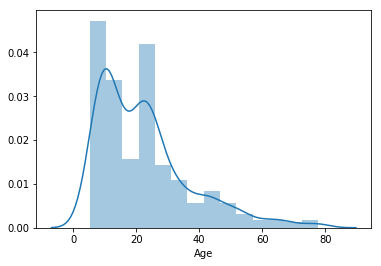

In [78]:
sns.distplot(nndsp_pheno.age_at_scan, bins = num_bins(nndsp_pheno, "age_at_scan"), axlabel="Age")
pyplot.show()

## Resampling NKI

In [119]:
nki_pheno = pd.read_csv(nki_phenoFile, sep='\t')

In [120]:
nki_pheno = nki_pheno[['participant_id', 'age']]
nki_pheno.participant_id = [int(x[1:]) for x in nki_pheno.participant_id]
nki_pheno = nki_pheno.sort_values(by='age')
nki_pheno.head()

,participant_id,age
714,62349,6.0
901,51691,6.0
902,56020,6.0
775,65185,6.0
904,40117,6.0


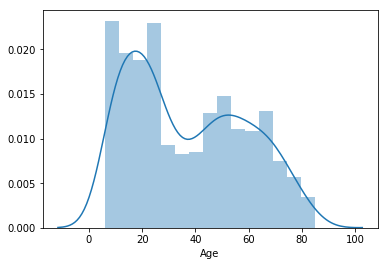

In [51]:
sns.distplot(nki_pheno.age, bins = num_bins(nki_pheno, "age"), axlabel="Age")
pyplot.show()

### NKI:NNDSP

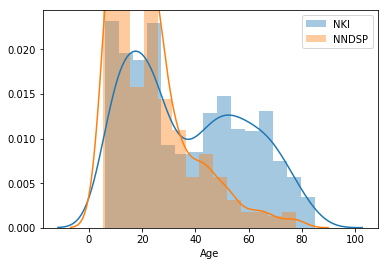

In [94]:
sns.distplot(nki_pheno.age, bins = num_bins(nki_pheno, "age"), axlabel="Age", label = "NKI")
sns.distplot(nndsp_pheno.age_at_scan, bins = num_bins(nndsp_pheno, "age_at_scan"), axlabel="Age", label = "NNDSP")
pyplot.legend()
pyplot.show()

In [134]:
nki_dist = get_bucket_dist(nki_pheno, "age", to_print=False)
nndsp_dist = get_bucket_dist(nndsp_pheno, "age_at_scan", to_print=True)

0-5 :  0
5-10 :  97
10-15 :  82
15-20 :  37
20-25 :  85
25-30 :  42
30-35 :  27
35-40 :  11
40-45 :  23
45-50 :  9
50-55 :  13
55-60 :  2
60-65 :  5
65-70 :  5
70-75 :  0
75-80 :  4
80-85 :  0
85-90 :  0
90-95 :  0
95-100 :  0


In [175]:
df_dist_nki = df_from_dist(nki_pheno, "age", "participant_id", nki_dist, nndsp_pheno, nndsp_dist)
df_dist_nki = df_dist_nki.sort_values(by='age')

    participant_id   age
68           31217  18.0
    participant_id   age
50           29215  54.0
    participant_id   age
14           28207  26.0
    participant_id   age
61           30981  15.0
    participant_id   age
22           28399  53.0
    participant_id   age
29           28656  20.0
   participant_id   age
9           28150  44.0
    participant_id   age
10           28152  51.0
    participant_id   age
32           28694  25.0
    participant_id   age
28           28625  73.0
    participant_id   age
66           31167  47.0
    participant_id   age
35           28766  19.0
   participant_id   age
8           27651  68.0
    participant_id   age
54           29303  19.0
    participant_id   age
42           28912  67.0
    participant_id   age
26           28468  46.0
    participant_id   age
62           30989  30.0
    participant_id   age
33           28753  41.0
    participant_id   age
48           29104  44.0
    participant_id   age
40           28845  76.0
   p

     participant_id   age
366           50679  81.0
     participant_id  age
293           40556  9.0
     participant_id   age
286           40462  47.0
     participant_id   age
336           43704  27.0
     participant_id   age
347           44068  79.0
     participant_id   age
318           43282  16.0
     participant_id   age
346           44012  19.0
     participant_id   age
272           40248  77.0
     participant_id   age
334           43649  22.0
     participant_id  age
315           41503  8.0
     participant_id   age
358           44405  49.0
     participant_id   age
353           44291  24.0
     participant_id   age
270           40182  71.0
     participant_id   age
354           44344  63.0
     participant_id   age
348           44084  17.0
     participant_id   age
340           43758  16.0
     participant_id   age
339           43740  14.0
     participant_id   age
372           50848  16.0
     participant_id   age
361           44427  75.0
     participant

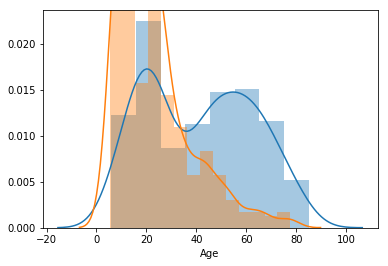

In [143]:
sns.distplot(df_dist_nki.age)
sns.distplot(nndsp_pheno.age_at_scan, bins = num_bins(nndsp_pheno, "age_at_scan"), axlabel="Age", label = "NNDSP")
pyplot.show()

In [129]:
len(df_dist_nki)

416

### NKI:HCP

## Resampling CORRS

In [66]:
corrs_pheno = pd.read_csv(corrs_phenoFile)

In [69]:
corrs_pheno = corrs_pheno[["SUBID", "AGE_AT_SCAN_1"]]
corrs_pheno = corrs_pheno.drop_duplicates()
corrs_pheno = corrs_pheno[corrs_pheno.AGE_AT_SCAN_1 != "NoPhenotypicData"]
corrs_pheno = corrs_pheno[corrs_pheno.AGE_AT_SCAN_1 != "#"]
corrs_pheno.AGE_AT_SCAN_1 = [float(x) for x in corrs_pheno.AGE_AT_SCAN_1]
corrs_pheno.head()

,SUBID,AGE_AT_SCAN_1
0,3001,25.13
2,3002,23.96
4,3004,31.15
6,3006,23.00
8,3007,43.53


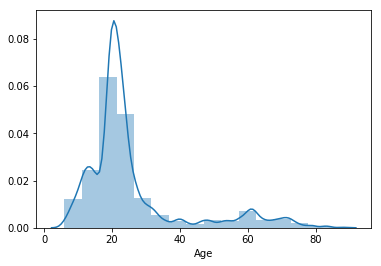

In [70]:
sns.distplot(corrs_pheno.AGE_AT_SCAN_1, bins = num_bins(corrs_pheno, "AGE_AT_SCAN_1"), axlabel="Age")
pyplot.show()

### CORRS:NNDSP

### CORRS:HCP

## Resampling SALD

In [72]:
sald_pheno = pd.read_excel(sald_phenoFile)

In [75]:
sald_pheno = sald_pheno[['Sub_ID', 'Age']]
sald_pheno.head()

,Sub_ID,Age
0,31274,72
1,31275,44
2,31276,74
3,31277,60
4,31278,55


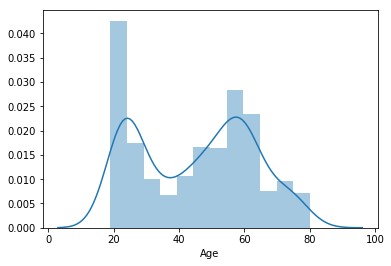

In [77]:
sns.distplot(sald_pheno.Age, bins = num_bins(sald_pheno, "Age"), axlabel="Age")
pyplot.show()

### SALD:NNDSP

### SALD:HCP